# Greedy algorithms for reduced basis computation

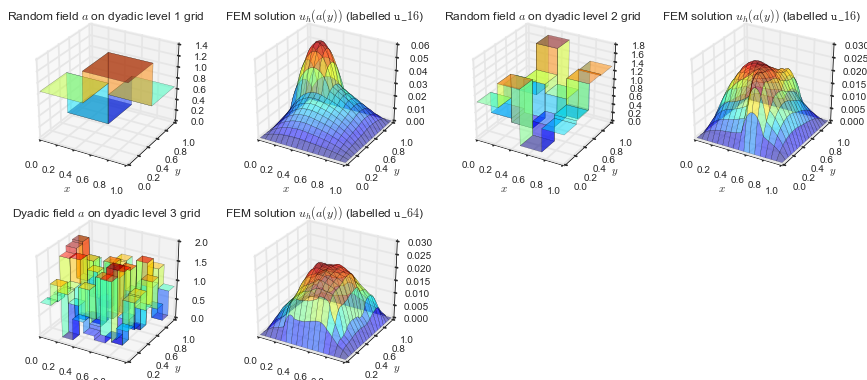

In [66]:
import numpy as np
import importlib
import dyadic_fem as df
import point_generator as pg
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
importlib.reload(df)
importlib.reload(pg)
%matplotlib inline

fem_div = 7

a_bar = 1.0
c = 0.9

a_4 = df.make_dyadic_random_field(div=1, a_bar=a_bar, c=c, seed=1)
fem_4 = df.DyadicFEMSolver(div=fem_div, rand_field=a_4, f=1.0)
fem_4.solve()

a_16 = df.make_dyadic_random_field(div=2, a_bar=a_bar, c=c, seed=1)
fem_16 = df.DyadicFEMSolver(div=fem_div, rand_field=a_16, f=1.0)
fem_16.solve()

a_64 = df.make_dyadic_random_field(div=3, a_bar=a_bar, c=c, seed=1)
fem_64 = df.DyadicFEMSolver(div=fem_div, rand_field=a_64, f=1.0)
fem_64.solve()

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(3, 4, 1, projection='3d')
a_4.plot(ax, title='Random field $a$ on dyadic level 1 grid')
ax = fig.add_subplot(3, 4, 2, projection='3d')
fem_4.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_16}$)')
ax = fig.add_subplot(3, 4, 3, projection='3d')
a_16.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(3, 4, 4, projection='3d')
fem_16.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_16}$)')
ax = fig.add_subplot(3, 4, 5, projection='3d')
a_64.plot(ax, title='Dyadic field $a$ on dyadic level 3 grid')
ax = fig.add_subplot(3, 4, 6, projection='3d')
fem_64.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_64}$)')
plt.show()

In [37]:
# First we need a point process generator
basis_div = 3
d = 2**basis_div * 2**basis_div
nD = 2048 # The number of points in our dictionary
point_gen = pg.MonteCarlo(d, nD, lims=[-1, 1], seed=1)

n = 150 # size of basis

print('Generated point set')

# Now we feed that in to the field generatr
D = []
fields = []
norms = np.zeros(nD)

print('Generating dictionary point: ', end='')
for i in range(nD):
    field = df.DyadicPWConstant(a_bar + c * point_gen.points[:,i].reshape([2**basis_div,2**basis_div]), div=basis_div)
    fields.append(field)
    # Then the fem solver (there a faster way to do this all at once? This will be huge...
    fem_solver = df.DyadicFEMSolver(div=fem_div, rand_field = field, f = 1)
    fem_solver.solve()
    D.append(fem_solver.u)
    norms[i] = D[-1].norm(space='H1')
    
    if i % 50 == 0:
        print('{0}... '.format(i), end='')
    
# First find the maximum point by norm in this space
n0 = np.argmax(norms)

# We put in the first element - and make the flat values array large so 
# that it is essentially pre-allocated, for optimisation purposes...
val_flat = np.zeros(np.append(D[0].values.shape, n))
val_flat[:,:,0] = D[n0].values
Vn_greedy = df.Basis([D[n0]], space='H1', values_flat=val_flat)

Vn_greedy.make_grammian()

print('\n\nGenerating basis from greedy algorithm with dictionary: ')
print('i \t || phi_i || \t\t || phi_i - P_V_(i-1) phi_i ||')
# Now we start building the basis
for i in range(1, n):
    
    # Now we go through the dictionary and find the max of || f ||^2 - || P_Vn f ||^2
    p_V_d = np.zeros(nD)
    for j in range(nD):
        p_V_d[j] = Vn_greedy.project(D[j]).norm('H1')
        
    nj = np.argmax(norms * norms - p_V_d * p_V_d)
    
    Vn_greedy.add_vector(D[nj])
    
    print('{0} : \t {1} \t {2}'.format(i, norms[nj], norms[nj]*norms[nj] - p_V_d[nj] * p_V_d[nj]))
    
    #if i % 10 == 0:
    #    print('{0}... '.format(i), end='')
        
print('\n\nDone!')

Generated point set
Generating dictionary point: 0... 50... 100... 150... 200... 250... 300... 350... 400... 450... 500... 550... 600... 650... 700... 750... 800... 850... 900... 950... 1000... 1050... 1100... 1150... 1200... 1250... 1300... 1350... 1400... 1450... 1500... 1550... 1600... 1650... 1700... 1750... 1800... 1850... 1900... 1950... 2000... 

Generating basis from greedy algorithm with dictionary: 
i 	 || phi_i || 		 || phi_i - P_V_(i-1) phi_i ||
1 : 	 0.006568417144130461 	 3.0549278534273034e-05
2 : 	 0.005760091605704188 	 2.200576601496628e-05
3 : 	 0.005918410045708678 	 1.8397357906631758e-05
4 : 	 0.006533415556703132 	 1.6941040627098744e-05
5 : 	 0.0061550806020614105 	 1.669194049843973e-05
6 : 	 0.0061586415505372055 	 1.47633004116326e-05
7 : 	 0.005718559653792809 	 1.3946306554213653e-05
8 : 	 0.005992046126447897 	 1.3609662487150412e-05
9 : 	 0.006121531535483614 	 1.2867044088019769e-05
10 : 	 0.005301828239968857 	 1.2850037215717308e-05
11 : 	 0.0062674832

In [40]:
import time
div_levels = range(2,5)
ns = np.zeros(len(div_levels))
sin_err = []
sin_ns = []
hat_err = []
hat_ns = []
red_err = []
red_ns = []
grb_err = []
grb_ns = []

Vn_sin = df.make_sin_basis(fem_div, N=2**(fem_div-2), space='H1')
Vn_red, Vn_red_fields = df.make_reduced_basis(n=n, field_div=basis_div, fem_div=fem_div, space='H1', a_bar=a_bar, c=c)

ns = range(2,n,4)

for i in ns:
    Vn_sin_i = Vn_sin.subspace(slice(0,i))
    Vn_red_i = Vn_red.subspace(slice(0,i))
    Vn_greedy_i = Vn_greedy.subspace(slice(0,i))
    
    sin_err.append((Vn_sin_i.project(fem_64.u) - fem_64.u).norm(space='H1'))
    red_err.append((Vn_red_i.project(fem_64.u) - fem_64.u).norm(space='H1'))
    grb_err.append((Vn_greedy_i.project(fem_64.u) - fem_64.u).norm(space='H1'))    

for i, coarse_div in enumerate(div_levels):
    Vn_hat_i = df.make_hat_basis(div=coarse_div, space='H1')
    hat_err.append((Vn_hat_i.project(fem_64.u) - fem_64.u).norm(space='H1'))

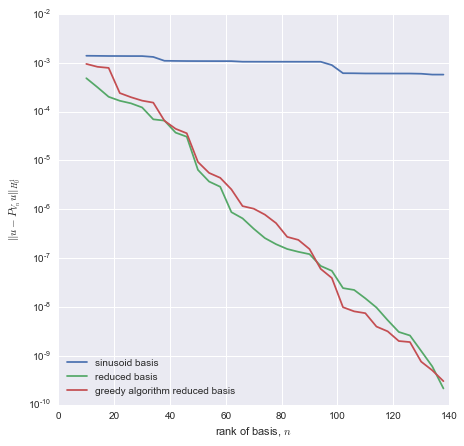

In [84]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
plt.plot(ns, sin_err, label='sinusoid basis')
#plt.plot(2**np.array(div_levels)*2**np.array(div_levels), hat_err, label='hat basis')
plt.plot(ns, red_err, label='reduced basis')
plt.plot(ns, grb_err, label='greedy algorithm reduced basis') 
ax.set(xlabel='rank of basis, $n$', ylabel='$\|u - P_{V_n} u\|_{H_0^1}$')
plt.legend(loc=3)
plt.show()

### Hmm, didn't seem to work as well as planned. Lets try the library implemented version now.

In [81]:
basis_div = 2

pd = pg.MonteCarlo(d=16, n=4000, lims=[-1, 1], seed=1)

ns = np.zeros(len(div_levels))
sin_err = []
sin_ns = []
hat_err = []
hat_ns = []
red_err = []
red_ns = []
grb_err = []
grb_ns = []

short_n = 140
Vn_greedy_sm = df.greedy_reduced_basis_construction(n=short_n, field_div=basis_div, fem_div=fem_div, \
                                                    point_dictionary = pd, a_bar=a_bar, c=c, verbose=True)
Vn_sin = df.make_sin_basis(fem_div, N=2**(fem_div-2), space='H1')
Vn_red, Vn_red_fields = df.make_reduced_basis(n=n, field_div=basis_div, fem_div=fem_div, space='H1', a_bar=a_bar, c=c)

ns = range(10,short_n,4)

for i in ns:
    Vn_sin_i = Vn_sin.subspace(slice(0,i))
    Vn_red_i = Vn_red.subspace(slice(0,i))
    Vn_greedy_i = Vn_greedy_sm.subspace(slice(0,i))
    
    sin_err.append((Vn_sin_i.project(fem_16.u) - fem_16.u).norm(space='H1'))
    red_err.append((Vn_red_i.project(fem_16.u) - fem_16.u).norm(space='H1'))
    grb_err.append((Vn_greedy_i.project(fem_16.u) - fem_16.u).norm(space='H1'))    

for i, coarse_div in enumerate(div_levels):
    Vn_hat_i = df.make_hat_basis(div=coarse_div, space='H1')
    hat_err.append((Vn_hat_i.project(fem_16.u) - fem_16.u).norm(space='H1'))


Generated point set
Generating dictionary point: 0... 50... 100... 150... 200... 250... 300... 350... 400... 450... 500... 550... 600... 650... 700... 750... 800... 850... 900... 950... 1000... 1050... 1100... 1150... 1200... 1250... 1300... 1350... 1400... 1450... 1500... 1550... 1600... 1650... 1700... 1750... 1800... 1850... 1900... 1950... 2000... 2050... 2100... 2150... 2200... 2250... 2300... 2350... 2400... 2450... 2500... 2550... 2600... 2650... 2700... 2750... 2800... 2850... 2900... 2950... 3000... 3050... 3100... 3150... 3200... 3250... 3300... 3350... 3400... 3450... 3500... 3550... 3600... 3650... 3700... 3750... 3800... 3850... 3900... 3950... 

Generating basis from greedy algorithm with dictionary: 
i 	 || phi_i || 		 || phi_i - P_V_(i-1) phi_i ||
1 : 	 0.012468985986070366 	 0.00013892787213968372
2 : 	 0.012621135076588089 	 0.00011574494963374933
3 : 	 0.012387848600604403 	 0.00011054368471305462
4 : 	 0.011627575151651496 	 8.8031687055379e-05
5 : 	 0.0114385212716

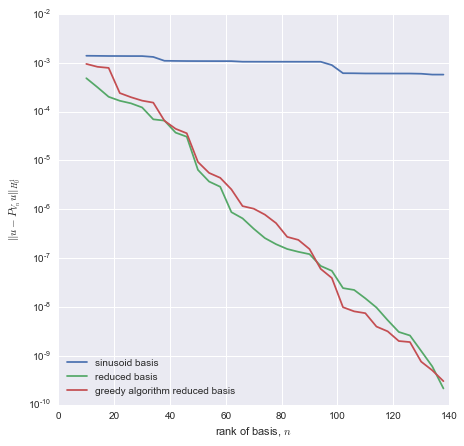

In [82]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(yscale="log")
plt.plot(ns, sin_err, label='sinusoid basis')
#plt.plot(2**np.array(div_levels)*2**np.array(div_levels), hat_err, label='hat basis')
plt.plot(ns, red_err, label='reduced basis')
plt.plot(ns, grb_err, label='greedy algorithm reduced basis') 
ax.set(xlabel='rank of basis, $n$', ylabel='$\|u - P_{V_n} u\|_{H_0^1}$')
plt.legend(loc=3)
plt.show()